# Standardising Australia Hazard Maps

The goal of this notebook is to develop and provide examples of mapping climate hazards for Australia so that data can be consistently presented.
Examples will include maps for Australia and for selected states or regions.

In [1]:
import datetime
datetime.datetime.today().date()

datetime.date(2024, 6, 26)

In [2]:
# this code is designed to work with hh5 analysis3-24.04 venv
import sys
print(sys.executable)

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/bin/python


In [3]:
cd /g/data/mn51/users/gt3409/plotting_maps/

/g/data/mn51/users/gt3409/plotting_maps


# import packages used in this workflow


In [4]:
from acs_plotting_maps import plot_acs_hazard, regions_dict, cmap_dict, tick_dict
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs


# Suggested colormaps and scales

Using suggested colormaps and scales will improve the consistency across teams producing similar variables. This will support comparison across different plots.
- see many colormaps here: https://www.ncl.ucar.edu/Document/Graphics/color_table_gallery.shtml

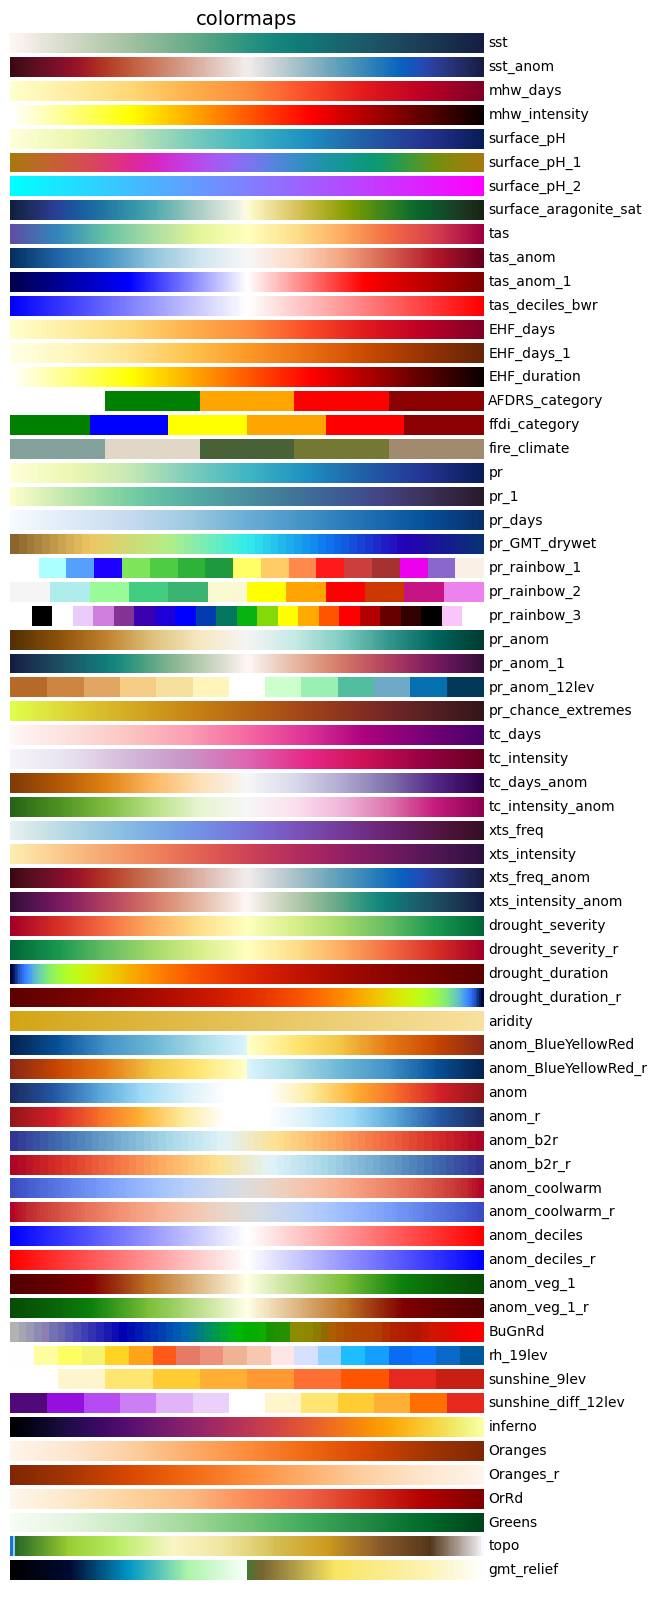

In [5]:
# visualise all the colormaps
nrows = len(cmap_dict)
figh = 0.35 + 0.15 + (nrows + (nrows - 1) * 0.1) * 0.22
fig, axs = plt.subplots(nrows=nrows + 1, figsize=(6.4, figh),)
fig.subplots_adjust(top=1 - 0.35 / figh, bottom=0.15 / figh,
                    left=0.01, right=0.75)

gradient = np.vstack((np.linspace(0, 1, 256), np.linspace(0, 1, 256)))
for ax, name in zip(axs, list(cmap_dict.keys())):
    ax.imshow(gradient, aspect='auto', cmap=cmap_dict[name])
    ax.text(1.01, 0.5, name, va='center', ha='left', fontsize=10,
            transform=ax.transAxes)

# Turn off *all* ticks & spines, not just the ones with colormaps.
for ax in axs:
    ax.set_axis_off()

axs[0].set_title(f'colormaps', fontsize=14)

plt.savefig("colormaps_aus_maps.png",dpi=100,facecolor='lightgray',)

In [6]:
# This dictionary gives some suggestions on the scale of the colour map to use for some variables. The scales are taken from cliamte maps on bom.gov.au/climate
tick_dict.keys()
             

dict_keys(['pr_annual', 'pr_6mon', 'pr_3mon', 'pr_mon', 'pr_hour', 'pr_days', 'pr_anom_mon', 'pr_anom_3mon', 'pr_anom_6mon', 'pr_anom_ann', 'pr_diff_mon', 'pr_diff_ann', 'frost_days', 'frost_days_mon', 'tas', 'tas_anom_day', 'tas_anom_mon', 'tas_anom_ann', 'apparent_tas', 'percent', 'xts_freq', 'fire_climate_ticks', 'fire_climate_labels', 'aridity_index_ticks', 'aridity_index_labels'])

# Load the State and Region shape files

In [7]:
# write a dictionary of the shapefile geopandas dataframes. These will be used for state boundaries, LGAs, NRM, etc
regions_dict.keys()

    

dict_keys(['aus_local_gov', 'aus_states_territories', 'australia', 'nrm_regions', 'river_regions', 'ncra_regions', 'broadacre_regions'])

# Define single function for plotting maps

# Example plots

## Example 1: Australia map only
These plots show the state/ region borders without data

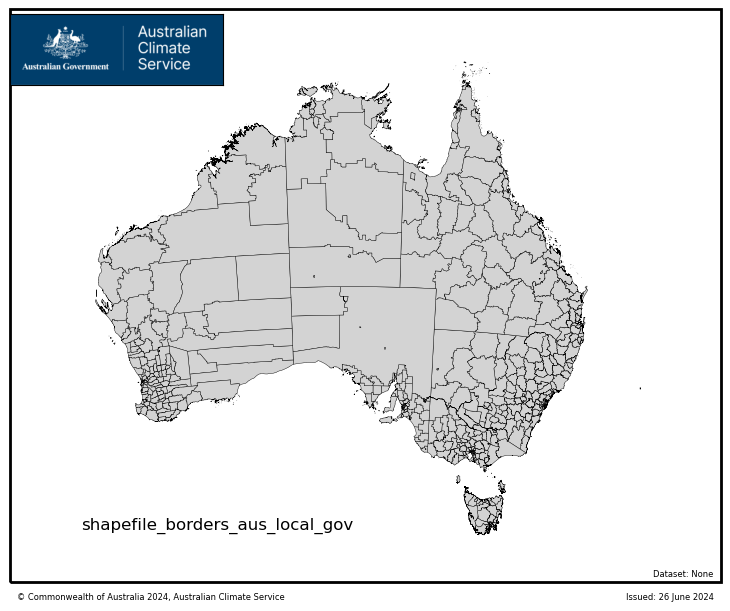

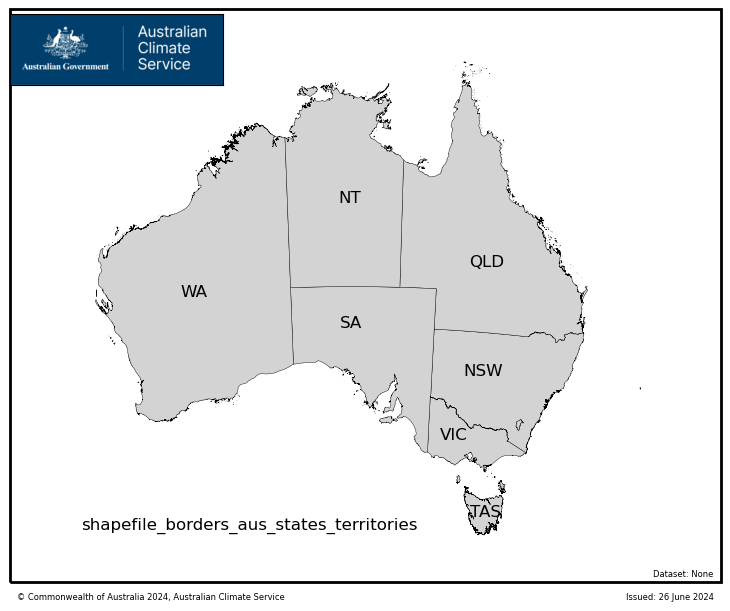

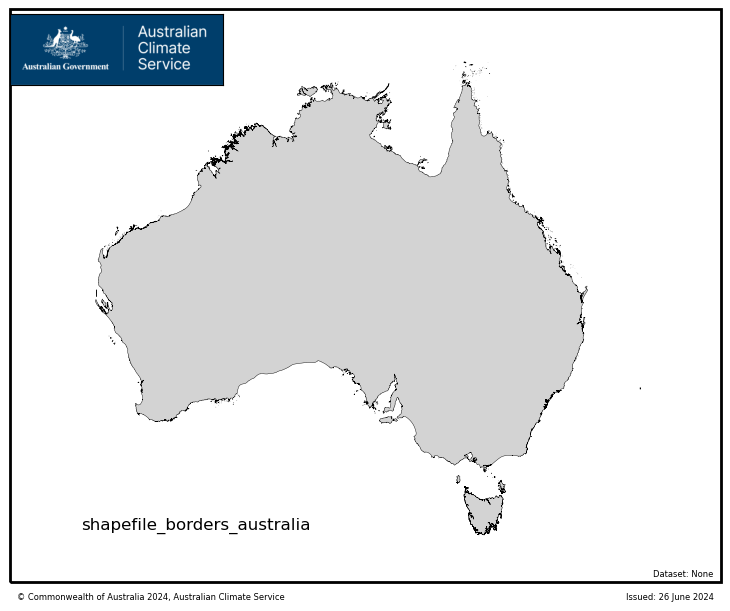

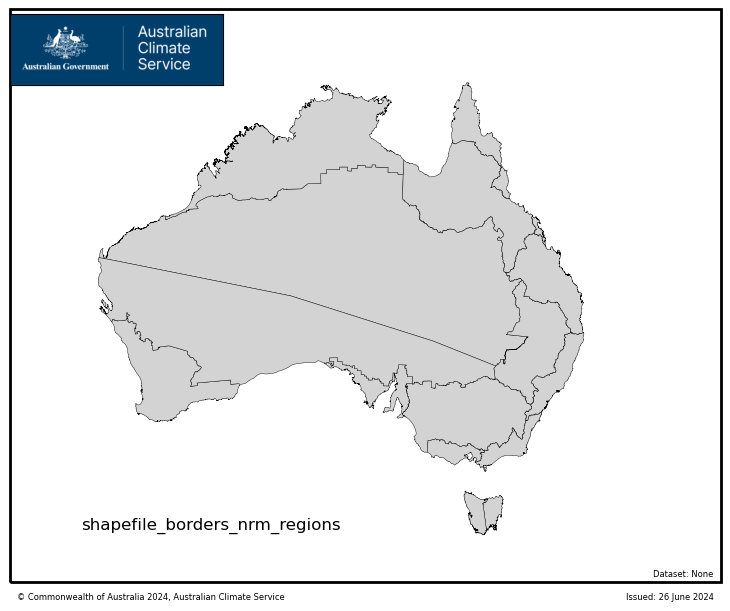

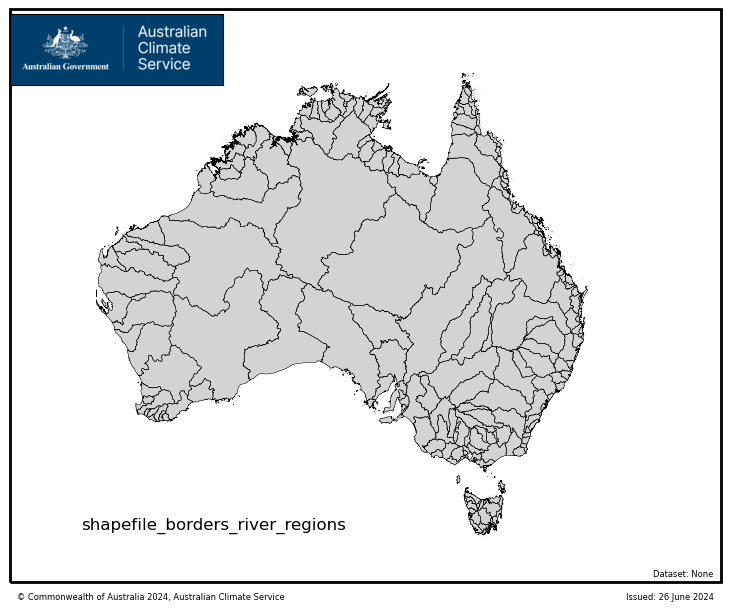

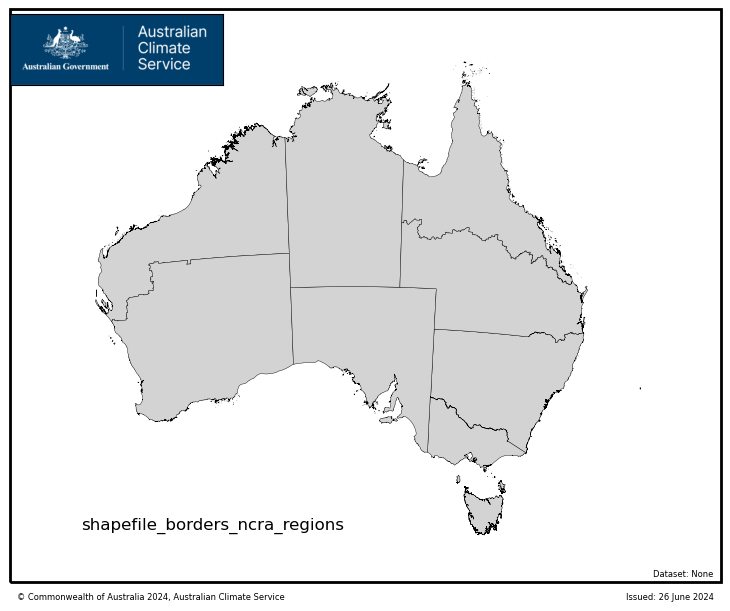

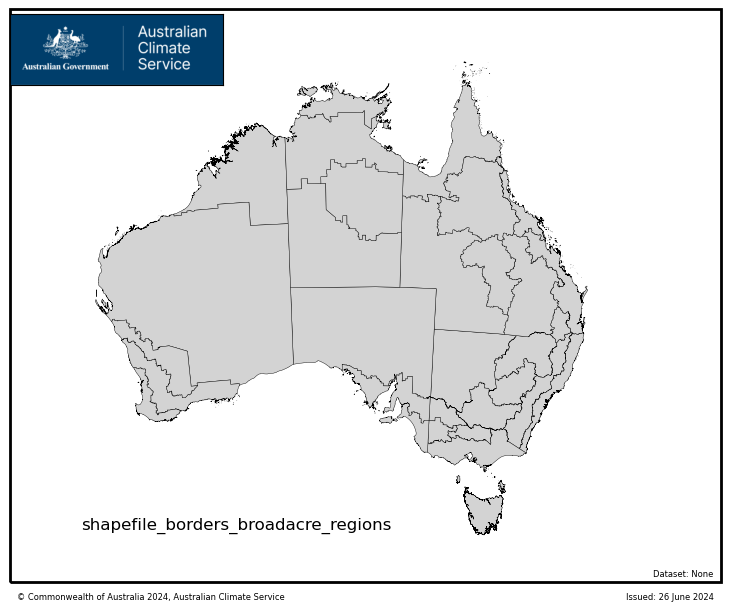

In [8]:
# Plot the shapefiles to see the borders

facecolor = "lightgrey"
xlim = (110,160)
ylim = (-45, -5)

for name in regions_dict.keys():
    
    plot_acs_hazard(name = name,
                        regions = regions_dict[name],
                        facecolor = facecolor, 
                        xlim = xlim,
                        ylim = ylim,
                        label_states = True,
                        title=f"shapefile_borders_{name}",
                        watermark=None);


## Examples with data
Load some temperature and rainfall data

In [9]:
# Load some hazard data

In [11]:
# load some rainfall data
ds_pr = xr.open_dataset("/g/data/ia39/australian-climate-service/test-data/CORDEX-CMIP6/bias-adjustment-input/AGCD-05i/BOM/ACCESS-CM2/historical/r4i1p1f1/BARPA-R/v1-r1/day/pr/pr_AGCD-05i_ACCESS-CM2_historical_r4i1p1f1_BOM_BARPA-R_v1-r1_day_19600101-19601231.nc")
# annual total rainfall
da_pr_ann = ds_pr.sum(dim="time").pr
# rainfall for one month
da_pr_jan = ds_pr.sel(time = ds_pr.time.dt.month==1).sum(dim="time").pr
# rainfall anomaly for one month
da_pr_anom = da_pr_jan-da_pr_ann/12


In [13]:
# load some temperature data
ds_tasmax = xr.open_dataset("/g/data/ia39/australian-climate-service/test-data/CORDEX-CMIP6/bias-adjustment-input/AGCD-05i/BOM/ACCESS-CM2/ssp370/r4i1p1f1/BARPA-R/v1-r1/day/tasmax/tasmax_AGCD-05i_ACCESS-CM2_ssp370_r4i1p1f1_BOM_BARPA-R_v1-r1_day_20150101-20151231.nc")
da_tasmax = ds_tasmax.tasmax.max(dim="time")
da_tasmax_anom = ds_tasmax.tasmax.max(dim="time") - ds_tasmax.tasmax.mean(dim="time")

## Example 2: Australia plots with data

State lines on Australia, with rainfall and temperature data

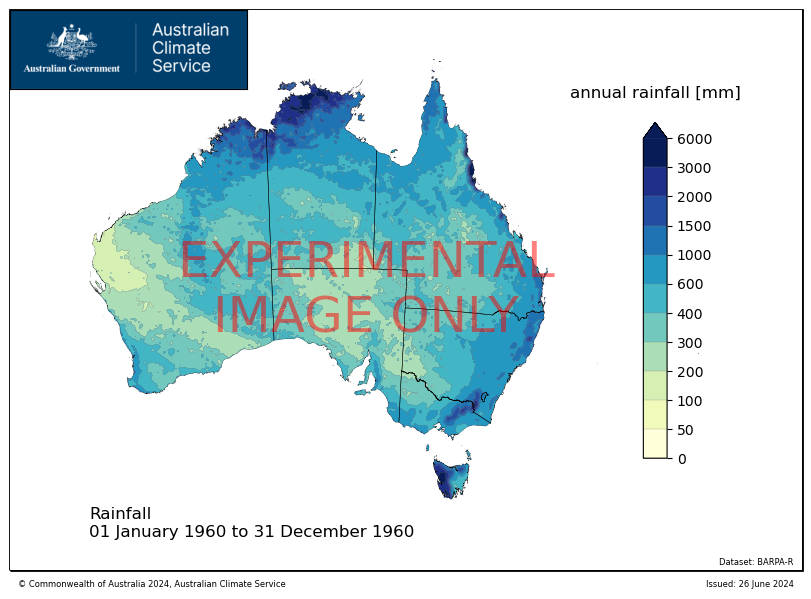

In [14]:
# Annual cummulative Rainfall

start = datetime.datetime.strptime(ds_pr.time_coverage_start, '%Y%m%dT%H%MZ').strftime("%d %B %Y")
end = datetime.datetime.strptime(ds_pr.time_coverage_end, '%Y%m%dT%H%MZ').strftime("%d %B %Y")

plot_acs_hazard(data = da_pr_ann,
                    regions = regions_dict['aus_states_territories'],
                   cmap=cmap_dict["pr"],
                   ticks=tick_dict['pr_annual'],
                   cbar_label="annual rainfall [mm]",
                   cbar_extend="max",
                    title = "Rainfall",
                   dataset_name = ds_pr.source_id,
                   date_range=f"{start} to {end}");

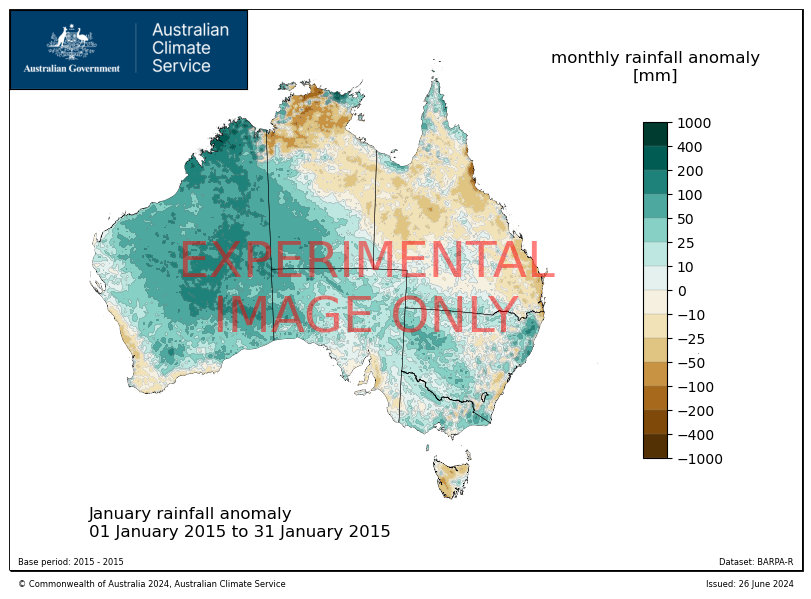

In [15]:
# Rainfall anomaly data

plot_acs_hazard(data = da_pr_anom,
                    regions = regions_dict['aus_states_territories'],
                   cmap=cmap_dict["pr_anom"],
                   ticks=tick_dict['pr_anom_mon'],
                   cbar_label="monthly rainfall anomaly\n[mm]",
                   title="January rainfall anomaly",
                   date_range=f"01 January 2015 to 31 January 2015",
                   baseline= "2015 - 2015",
                   dataset_name=ds_pr.source_id, 
                    );

In [16]:
# Temperature plots for Australia. Notice that the colorbar stays the same even though the plotted temperature ranges are different

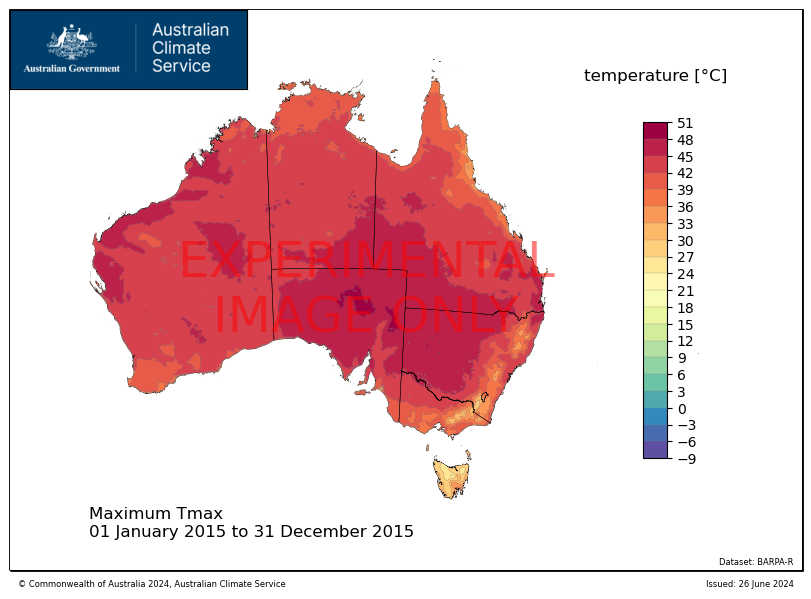

In [17]:
da_tasmax_max = ds_tasmax.tasmax.max(dim="time")

start = datetime.datetime.strptime(ds_tasmax.time_coverage_start, '%Y%m%dT%H%MZ').strftime("%d %B %Y")
end = datetime.datetime.strptime(ds_tasmax.time_coverage_end, '%Y%m%dT%H%MZ').strftime("%d %B %Y")

plot_acs_hazard(data = da_tasmax_max,
                    regions = regions_dict['aus_states_territories'],
                   cmap=cmap_dict["tas"],
                   ticks=tick_dict['tas'],
                    cbar_label="temperature [\N{DEGREE SIGN}C]",
                    title = "Maximum Tmax",
                    date_range=f"{start} to {end}",
                    dataset_name=ds_tasmax.source_id,
                   );

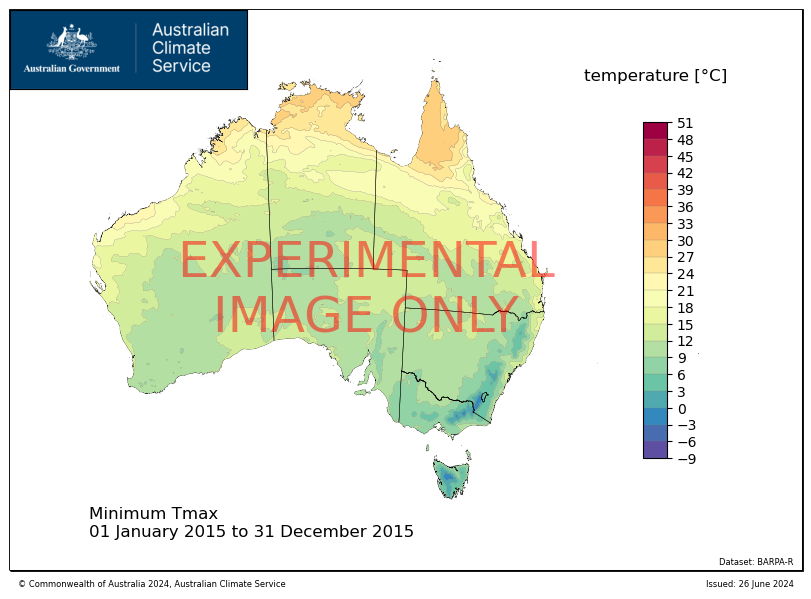

In [18]:
da_tasmax_min = ds_tasmax.tasmax.min(dim="time", keep_attrs=True)

start = datetime.datetime.strptime(ds_tasmax.time_coverage_start, '%Y%m%dT%H%MZ').strftime("%d %B %Y")
end = datetime.datetime.strptime(ds_tasmax.time_coverage_end, '%Y%m%dT%H%MZ').strftime("%d %B %Y")

plot_acs_hazard(data = da_tasmax_min,
                    regions = regions_dict['aus_states_territories'],
                   cmap=cmap_dict["tas"],
                   ticks=tick_dict['tas'],
                    cbar_label="temperature [\N{DEGREE SIGN}C]",
                    title = "Minimum Tmax",
                    date_range=f"{start} to {end}",
                    dataset_name=ds_tasmax.source_id,
                   );

## Example 3: Select areas
Plot data for selected areas/ states

In [19]:
# plot one state

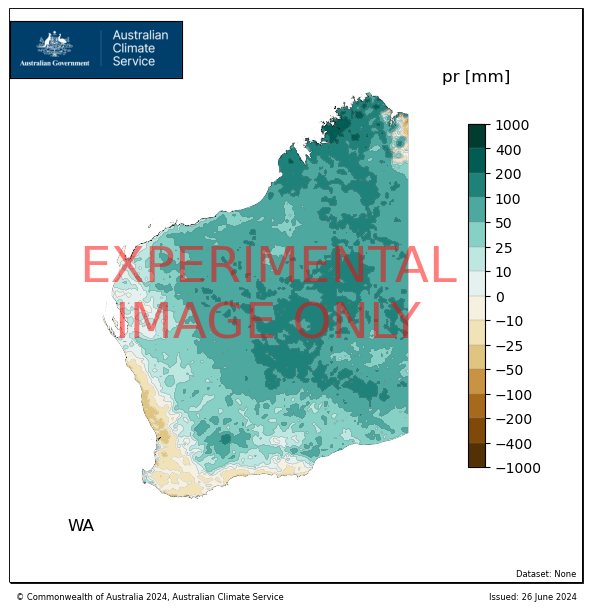

In [20]:
plot_acs_hazard(data = da_pr_anom,
                    regions = regions_dict['aus_states_territories'],
                   cmap=cmap_dict["pr_anom"],
                   ticks=tick_dict['pr_anom_mon'],
                   cbar_label="pr [mm]",
                   select_area=["Western Australia"],
                   figsize=(6,6),
                   title="WA", 
                   );

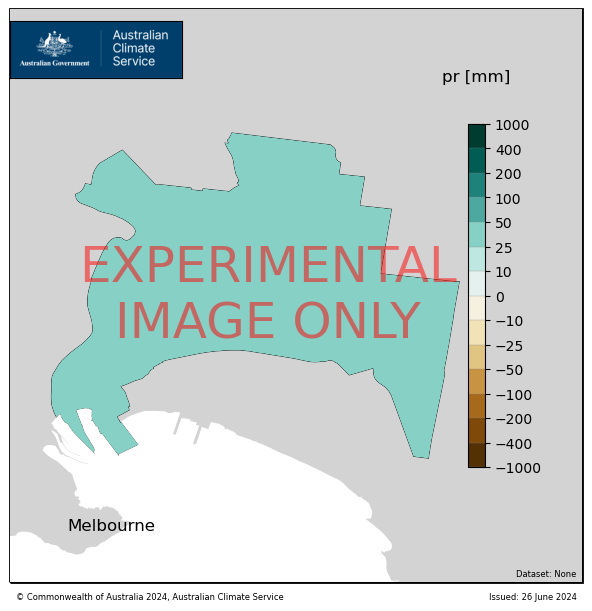

In [21]:
# Make sure that the regions is the right one for the desired areas
plot_acs_hazard(data = da_pr_anom,
                    regions = regions_dict['aus_local_gov'],
                   cmap=cmap_dict["pr_anom"],
                   ticks=tick_dict['pr_anom_mon'],
                   cbar_label="pr [mm]",
                   select_area=["Melbourne"],
                   figsize=(6,6),
                   title="Melbourne",
                   land_shadow=True);

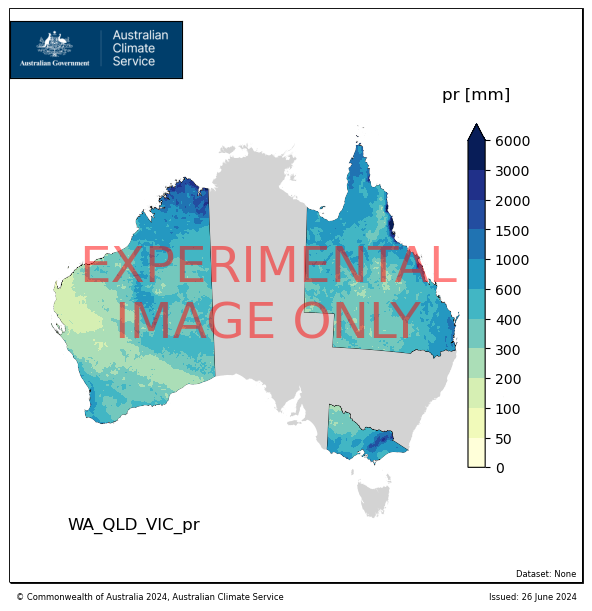

In [22]:
# select multiple non contiguous areas and show the area of non-selected australian land

fig, ax = plot_acs_hazard(data = da_pr_ann,
                              regions = regions_dict['aus_states_territories'],
                              cmap=cmap_dict["pr"],
                              cbar_label="pr [mm]",
                              ticks=tick_dict['pr_annual'],
                              cbar_extend="max",
                              select_area=["Victoria", "Western Australia", "Queensland"],
                              contourf=False,
                              figsize=(6,6),
                              contour=False,
                             land_shadow=True,
                             title = "WA_QLD_VIC_pr",
                             crs = ccrs.LambertConformal(central_latitude = -24.75, central_longitude = 134.0, cutoff=30, standard_parallels=(-10,-40)))


## Example 4: loop over areas to select and plot

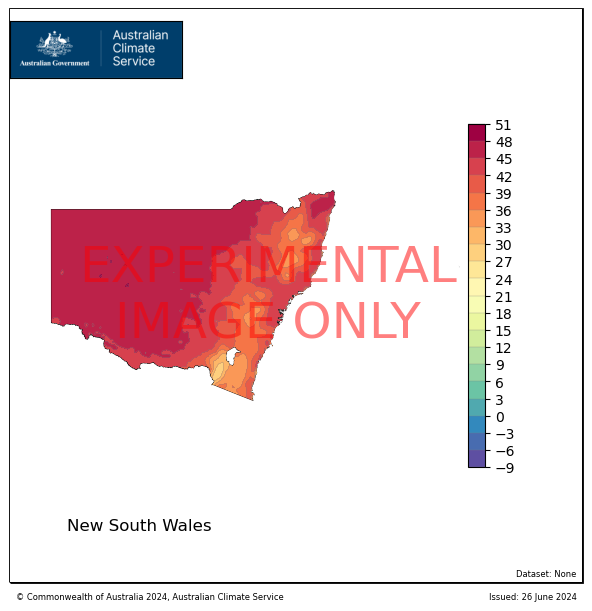

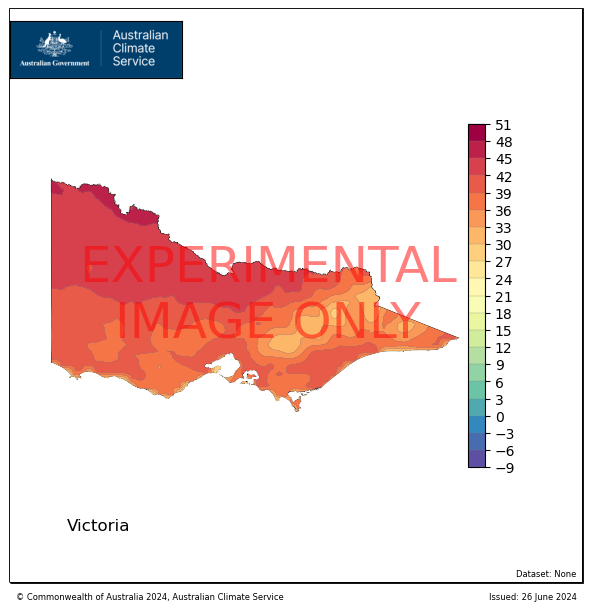

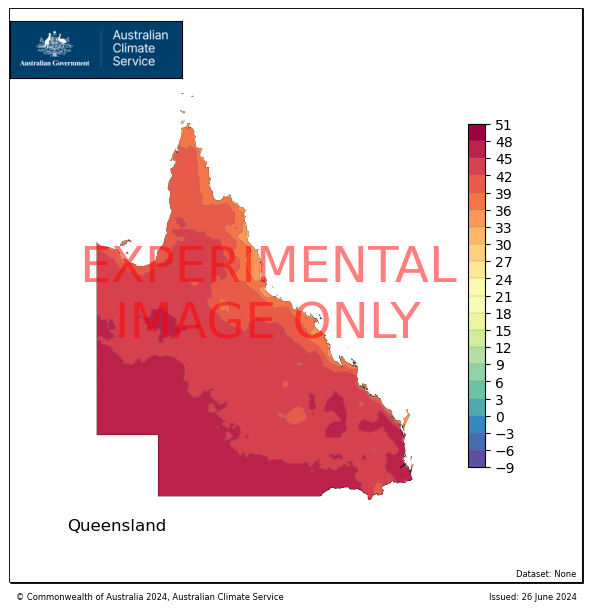

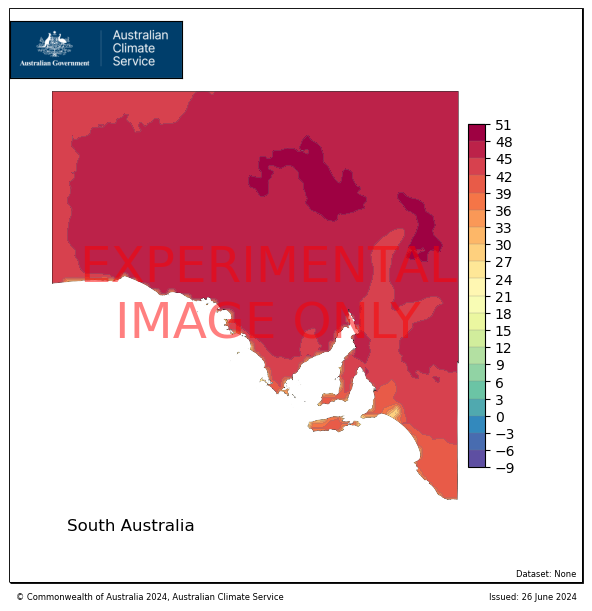

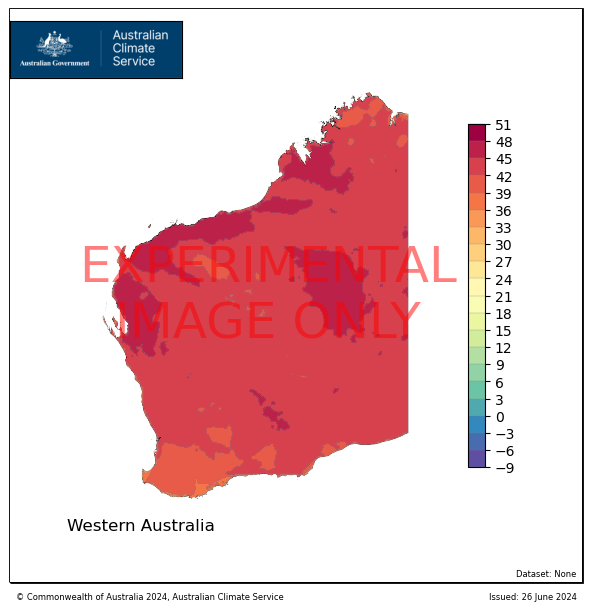

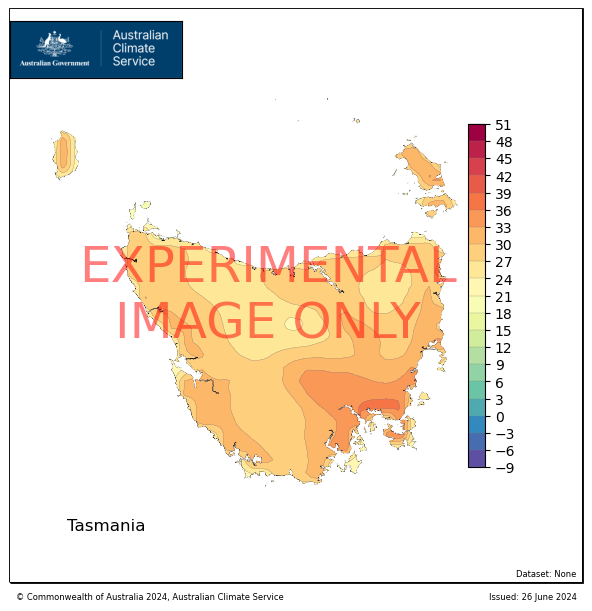

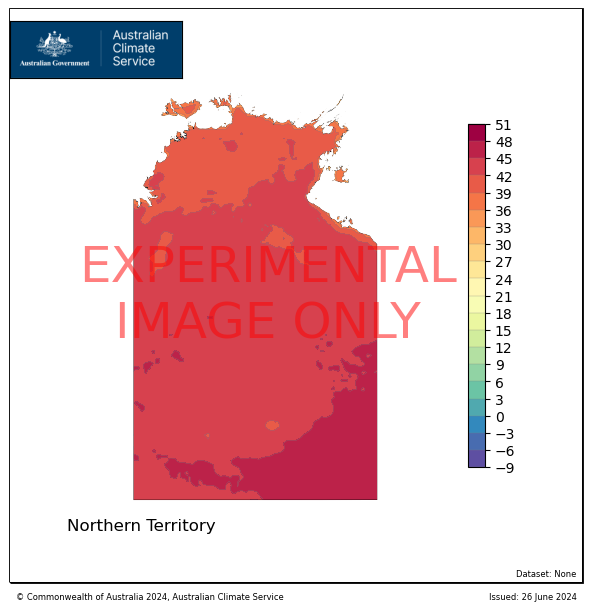

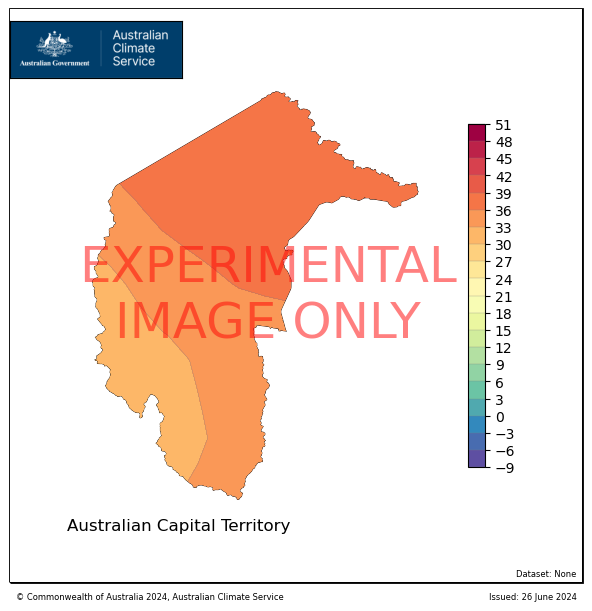

In [23]:
# loop over list of areas to cut out and make plots
regions = regions_dict['aus_states_territories']

for state in list(regions.STE_NAME21)[:-1]:
    plot_acs_hazard(data = da_tasmax_max,
                        figsize=(6,6),
                        regions = regions,
                       cmap=cmap_dict["tas"],
                       ticks=tick_dict['tas'],
                       contour=True,
                       select_area=[state],
                       title=state,);